In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

WORKING_DIR = 'C:/term_project/'
os.chdir(WORKING_DIR)
print(os.getcwd())

C:\term_project


In [2]:
# IMPORTS & CONFIG

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# LSTM imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
tf.get_logger().setLevel('ERROR')

DATA_DIR = os.path.join(WORKING_DIR, 'data')
RESULT_DIR = os.path.join(WORKING_DIR, 'results')

# Improved lag periods (focus on dengue incubation: 1-2 weeks + seasonal)
LAG_WEEKS = [1, 2, 3, 4, 8, 12, 26, 52]
ROLLING_WEEKS = [4, 8, 12, 26, 52]
EWM_SPANS = [4, 8, 12, 26]  # Exponential weighted moving averages

# City-specific oversampling thresholds
OVERSAMPLE_THRESHOLD_SJ = 30  # San Juan
OVERSAMPLE_THRESHOLD_IQ = 10  # Iquitos
OVERSAMPLE_MULTIPLIER = 2

# Use only horizon t+1 for simplicity
PREDICTION_HORIZON = 1

# Feature selection
MAX_FEATURES = 50
CORRELATION_THRESHOLD = 0.95  # Remove highly correlated features

# Time series CV folds
N_SPLITS = 5

# Optuna trials
N_TRIALS = 50

# LSTM sequence length
LSTM_SEQUENCE_LENGTH = 4

In [3]:
# LOAD DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan:", sj_train_features.shape)
print("Iquitos:", iq_train_features.shape)

San Juan: (936, 21)
Iquitos: (520, 21)


In [4]:
# PREPROCESS DATA

def preprocess_city_data(features, labels=None):
    """Merge features/labels, set datetime index, fill missing values."""
    df = features.join(labels) if labels is not None else features.copy()
    df.reset_index(inplace=True)
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    df.set_index('week_start_date', inplace=True)
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    df = df.ffill()
    return df

sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan:", sj_train.shape)
print("Iquitos:", iq_train.shape)

San Juan: (936, 23)
Iquitos: (520, 23)


In [5]:
sj_train.columns

Index(['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

In [6]:
# FEATURE ENGINEERING (Improved)

def create_features(df):
    """Create enhanced features including cyclical, interactions, EWM."""
    df_eng = df.copy()
    
    # 1. CYCLICAL TIME FEATURES (sin/cos encoding)
    df_eng['week_sin'] = np.sin(2 * np.pi * df_eng['weekofyear'] / 52)
    df_eng['week_cos'] = np.cos(2 * np.pi * df_eng['weekofyear'] / 52)
    df_eng['month'] = df_eng.index.month
    df_eng['month_sin'] = np.sin(2 * np.pi * df_eng['month'] / 12)
    df_eng['month_cos'] = np.cos(2 * np.pi * df_eng['month'] / 12)
    
    # Climate feature columns
    climate_cols = [c for c in df.columns if c not in ['total_cases', 'year', 'weekofyear']]
    
    # 2. INTERACTION FEATURES (temperature × humidity, etc.)
    temp_cols = [c for c in climate_cols if 'temp' in c.lower()]
    humid_cols = [c for c in climate_cols if 'humid' in c.lower()]
    precip_cols = [c for c in climate_cols if 'precip' in c.lower()]
    
    for temp_col in temp_cols[:2]:  # Limit interactions
        for humid_col in humid_cols[:2]:
            df_eng[f'{temp_col}_x_{humid_col}'] = df_eng[temp_col] * df_eng[humid_col]
        for precip_col in precip_cols[:1]:
            df_eng[f'{temp_col}_x_{precip_col}'] = df_eng[temp_col] * df_eng[precip_col]
    
    new_features = []
    
    for col in climate_cols:
        # 4. LAG FEATURES (focused on dengue incubation 1-2 weeks)
        for lag in LAG_WEEKS:
            new_features.append(df_eng[col].shift(lag).rename(f'{col}_lag_{lag}'))
        
        # ROLLING FEATURES
        for window in ROLLING_WEEKS:
            rolling = df_eng[col].rolling(window=window)
            new_features.append(rolling.mean().rename(f'{col}_roll_mean_{window}'))
            new_features.append(rolling.std().rename(f'{col}_roll_std_{window}'))
        
        # 3. EXPONENTIAL WEIGHTED MOVING AVERAGES
        for span in EWM_SPANS:
            new_features.append(df_eng[col].ewm(span=span).mean().rename(f'{col}_ewm_{span}'))
    
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
    
    # Drop year, weekofyear (replaced by cyclical)
    df_eng.drop(columns=['year', 'weekofyear', 'month'], inplace=True, errors='ignore')
    
    df_eng.dropna(inplace=True)
    return df_eng

sj_train_eng = create_features(sj_train)
iq_train_eng = create_features(iq_train)

print("San Juan Engineered:", sj_train_eng.shape)
print("Iquitos Engineered:", iq_train_eng.shape)

San Juan Engineered: (884, 471)
Iquitos Engineered: (468, 471)


In [7]:
# 11. HANDLE OUTLIERS - Clip extreme values

def clip_outliers(df, target_col='total_cases', upper_percentile=95):
    """Clip target outliers to reduce impact of extreme values."""
    df = df.copy()
    upper_bound = df[target_col].quantile(upper_percentile / 100)
    df[target_col] = df[target_col].clip(upper=upper_bound)
    print(f"Clipped {target_col} to max {upper_bound:.0f}")
    return df

sj_train_eng = clip_outliers(sj_train_eng)
iq_train_eng = clip_outliers(iq_train_eng)

Clipped total_cases to max 115
Clipped total_cases to max 29


In [8]:
# 17. REMOVE HIGHLY CORRELATED FEATURES

def remove_correlated_features(df, target_col='total_cases', threshold=CORRELATION_THRESHOLD):
    """Remove features with correlation > threshold."""
    feature_cols = [c for c in df.columns if c != target_col]
    corr_matrix = df[feature_cols].corr().abs()
    
    # Upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features to drop
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    
    print(f"Removing {len(to_drop)} highly correlated features")
    df = df.drop(columns=to_drop)
    return df

sj_train_eng = remove_correlated_features(sj_train_eng)
iq_train_eng = remove_correlated_features(iq_train_eng)

print("\nAfter removing correlated features:")
print("San Juan:", sj_train_eng.shape)
print("Iquitos:", iq_train_eng.shape)

Removing 150 highly correlated features
Removing 116 highly correlated features

After removing correlated features:
San Juan: (884, 321)
Iquitos: (468, 355)


In [9]:
# CATEGORY-BALANCED FEATURE SELECTION

# Define feature categories based on raw features
FEATURE_CATEGORIES = {
    'ndvi': ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'],
    'temperature': ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
                    'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_tdtr_k',
                    'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'],
    'humidity': ['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg'],
    'precipitation': ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 
                      'reanalysis_sat_precip_amt_mm', 'station_precip_mm'],
    'time': ['week_sin', 'week_cos', 'month_sin', 'month_cos']
}

MIN_FEATURES_PER_CATEGORY = 4
TOTAL_FEATURES = 50


def get_feature_category(feature_name):
    """Determine which category a feature belongs to."""
    for category, base_cols in FEATURE_CATEGORIES.items():
        for base_col in base_cols:
            if base_col in feature_name:
                return category
    return 'other'


def select_features_balanced(df, target_col='total_cases', total_features=TOTAL_FEATURES, 
                              min_per_category=MIN_FEATURES_PER_CATEGORY):
    """Select features ensuring minimum representation from each category."""
    feature_cols = [c for c in df.columns if c != target_col]
    X = df[feature_cols]
    y = df[target_col]
    
    # Get importance scores using XGBoost
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
    model.fit(X, y, verbose=False)
    
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    })
    importance['category'] = importance['feature'].apply(get_feature_category)
    importance = importance.sort_values('importance', ascending=False)
    
    selected = []
    category_counts = {cat: 0 for cat in FEATURE_CATEGORIES.keys()}
    category_counts['other'] = 0
    
    # Step 1: Select minimum from each category
    print("  Category-balanced selection:")
    for category in FEATURE_CATEGORIES.keys():
        cat_features = importance[importance['category'] == category]
        n_available = len(cat_features)
        n_select = min(min_per_category, n_available)
        top_cat = cat_features.head(n_select)['feature'].tolist()
        selected.extend(top_cat)
        category_counts[category] = len(top_cat)
        print(f"    {category}: {len(top_cat)} features (available: {n_available})")
    
    # Step 2: Fill remaining slots with top features not yet selected
    remaining_slots = total_features - len(selected)
    if remaining_slots > 0:
        remaining_features = importance[~importance['feature'].isin(selected)]
        top_remaining = remaining_features.head(remaining_slots)['feature'].tolist()
        selected.extend(top_remaining)
        
        # Count categories of additional features
        for feat in top_remaining:
            cat = get_feature_category(feat)
            category_counts[cat] = category_counts.get(cat, 0) + 1
    
    print(f"\n  Total selected: {len(selected)}")
    print(f"  Final category distribution:")
    for cat, count in category_counts.items():
        if count > 0:
            print(f"    {cat}: {count}")
    
    return selected


print("Selecting features for San Juan (balanced)...")
sj_selected = select_features_balanced(sj_train_eng)

print("\nSelecting features for Iquitos (balanced)...")
iq_selected = select_features_balanced(iq_train_eng)

# Filter to selected features
sj_train_final = sj_train_eng[sj_selected + ['total_cases']]
iq_train_final = iq_train_eng[iq_selected + ['total_cases']]

print(f"\nSan Juan final: {sj_train_final.shape}")
print(f"Iquitos final: {iq_train_final.shape}")

Selecting features for San Juan (balanced)...
  Category-balanced selection:
    ndvi: 4 features (available: 82)
    temperature: 4 features (available: 150)
    humidity: 4 features (available: 20)
    precipitation: 4 features (available: 66)
    time: 2 features (available: 2)

  Total selected: 50
  Final category distribution:
    ndvi: 9
    temperature: 25
    humidity: 4
    precipitation: 10
    time: 2

Selecting features for Iquitos (balanced)...
  Category-balanced selection:
    ndvi: 4 features (available: 88)
    temperature: 4 features (available: 179)
    humidity: 4 features (available: 20)
    precipitation: 4 features (available: 65)
    time: 2 features (available: 2)

  Total selected: 50
  Final category distribution:
    ndvi: 7
    temperature: 33
    humidity: 4
    precipitation: 4
    time: 2

San Juan final: (884, 51)
Iquitos final: (468, 51)


In [10]:
# 13. CREATE HORIZON TARGET (t+1 only for simplicity)

def create_horizon_target(df, target_col='total_cases', horizon=PREDICTION_HORIZON):
    """Create shifted target for t+n prediction."""
    df = df.copy()
    df['target'] = df[target_col].shift(-horizon)
    df = df.dropna(subset=['target'])
    return df

sj_train_final = create_horizon_target(sj_train_final)
iq_train_final = create_horizon_target(iq_train_final)

print(f"Using prediction horizon: t+{PREDICTION_HORIZON}")
print("San Juan:", sj_train_final.shape)
print("Iquitos:", iq_train_final.shape)

Using prediction horizon: t+1
San Juan: (883, 52)
Iquitos: (467, 52)


In [11]:
# 12. SAMPLE WEIGHTS (Recent samples weighted higher)

def create_sample_weights(n_samples, decay=0.995):
    """Create exponentially increasing weights for recent samples."""
    weights = np.array([decay ** (n_samples - i - 1) for i in range(n_samples)])
    weights = weights / weights.sum() * n_samples  # Normalize
    return weights

# 9. REDUCED OVERSAMPLING

def oversample_peaks(X, y, threshold, multiplier=OVERSAMPLE_MULTIPLIER):
    """Oversample high-case periods with city-specific threshold."""
    peak_mask = y > threshold
    if peak_mask.sum() == 0:
        return X, y
    
    X_peaks = X[peak_mask]
    y_peaks = y[peak_mask]
    
    X_list = [X]
    y_list = [y]
    for _ in range(multiplier):
        X_list.append(X_peaks)
        y_list.append(y_peaks)
    
    return pd.concat(X_list), pd.concat(y_list)

In [12]:
# 10. TIME SERIES CROSS-VALIDATION

def time_series_cv_score(model_fn, X, y, threshold, n_splits=N_SPLITS):
    """Evaluate model using time series cross-validation."""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Oversample training data with city-specific threshold
        X_train_os, y_train_os = oversample_peaks(X_train, y_train, threshold)
        
        # Sample weights
        weights = create_sample_weights(len(X_train_os))
        
        model = model_fn()
        if hasattr(model, 'fit'):
            try:
                model.fit(X_train_os, y_train_os, sample_weight=weights)
            except TypeError:
                model.fit(X_train_os, y_train_os)
        
        preds = np.maximum(model.predict(X_val), 0)
        mae = mean_absolute_error(y_val, preds)
        scores.append(mae)
    
    return np.mean(scores), np.std(scores)

In [13]:
# 8. HYPERPARAMETER TUNING WITH OPTUNA

def optimize_xgboost(X, y, threshold, n_trials=N_TRIALS):
    """Optimize XGBoost using Optuna with time series CV."""
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': 42,
            'n_jobs': -1
        }
        
        model_fn = lambda: xgb.XGBRegressor(**params)
        mean_mae, _ = time_series_cv_score(model_fn, X, y, threshold)
        return mean_mae
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    return study.best_params, study.best_value


def build_lstm_model(n_features, units=64, dropout=0.2, learning_rate=0.001):
    """Build LSTM model with given hyperparameters."""
    model = Sequential([
        LSTM(units, input_shape=(LSTM_SEQUENCE_LENGTH, n_features), return_sequences=True),
        Dropout(dropout),
        LSTM(units // 2),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mae')
    return model


def create_lstm_sequences(X, y, seq_length=LSTM_SEQUENCE_LENGTH):
    """Create sequences for LSTM training."""
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


# Default LSTM hyperparameters (no Optuna tuning)
DEFAULT_LSTM_PARAMS = {
    'units': 64,
    'dropout': 0.2,
    'learning_rate': 0.001,
    'batch_size': 32
}

In [14]:
# PREPARE DATA FOR TRAINING

def prepare_data(df, selected_features):
    """Prepare X and y from dataframe."""
    X = df[selected_features]
    y = df['target']
    return X, y

X_sj, y_sj = prepare_data(sj_train_final, sj_selected)
X_iq, y_iq = prepare_data(iq_train_final, iq_selected)

print("San Juan: X=", X_sj.shape, "y=", y_sj.shape)
print("Iquitos: X=", X_iq.shape, "y=", y_iq.shape)

San Juan: X= (883, 50) y= (883,)
Iquitos: X= (467, 50) y= (467,)


In [15]:
# TUNE SAN JUAN MODELS

print("="*60)
print(f"Optimizing San Juan XGBoost (threshold={OVERSAMPLE_THRESHOLD_SJ})...")
print("="*60)
sj_xgb_params, sj_xgb_score = optimize_xgboost(X_sj, y_sj, OVERSAMPLE_THRESHOLD_SJ)
print(f"Best XGBoost MAE: {sj_xgb_score:.4f}")
print(f"Best params: {sj_xgb_params}")

# Use default LSTM params (no optimization)
sj_lstm_params = DEFAULT_LSTM_PARAMS.copy()
print(f"\nUsing default LSTM params: {sj_lstm_params}")

Optimizing San Juan XGBoost (threshold=30)...


Best trial: 46. Best value: 17.8922: 100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Best XGBoost MAE: 17.8922
Best params: {'max_depth': 5, 'learning_rate': 0.046842598032362175, 'n_estimators': 254, 'subsample': 0.9027090495215803, 'colsample_bytree': 0.6558970653774383, 'min_child_weight': 1, 'reg_alpha': 0.09076908431067275, 'reg_lambda': 0.00016332483887883604}

Using default LSTM params: {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


In [16]:
# TUNE IQUITOS MODELS

print("="*60)
print(f"Optimizing Iquitos XGBoost (threshold={OVERSAMPLE_THRESHOLD_IQ})...")
print("="*60)
iq_xgb_params, iq_xgb_score = optimize_xgboost(X_iq, y_iq, OVERSAMPLE_THRESHOLD_IQ)
print(f"Best XGBoost MAE: {iq_xgb_score:.4f}")
print(f"Best params: {iq_xgb_params}")

# Use default LSTM params (no optimization)
iq_lstm_params = DEFAULT_LSTM_PARAMS.copy()
print(f"\nUsing default LSTM params: {iq_lstm_params}")

Optimizing Iquitos XGBoost (threshold=10)...


Best trial: 27. Best value: 5.40679: 100%|██████████| 50/50 [01:00<00:00,  1.21s/it]

Best XGBoost MAE: 5.4068
Best params: {'max_depth': 6, 'learning_rate': 0.18347621096145686, 'n_estimators': 187, 'subsample': 0.7348040358905688, 'colsample_bytree': 0.7990431776189327, 'min_child_weight': 1, 'reg_alpha': 0.002275992350671852, 'reg_lambda': 1.2677470161079325}

Using default LSTM params: {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


In [17]:
# 5. ENSEMBLE MODELS (XGBoost + LSTM + SVM)

def train_ensemble(X, y, xgb_params, lstm_params, threshold):
    """Train ensemble of XGBoost, LSTM, and SVM."""
    # Oversample and get weights with city-specific threshold
    X_os, y_os = oversample_peaks(X, y, threshold)
    weights = create_sample_weights(len(X_os))
    
    # Scaler for LSTM and SVM
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_os)
    
    # XGBoost
    xgb_model = xgb.XGBRegressor(**xgb_params, random_state=42, n_jobs=-1)
    xgb_model.fit(X_os, y_os, sample_weight=weights)
    
    # LSTM
    X_seq, y_seq = create_lstm_sequences(X_scaled, y_os.values if hasattr(y_os, 'values') else y_os)
    lstm_model = build_lstm_model(
        X_os.shape[1], 
        units=lstm_params.get('units', 64),
        dropout=lstm_params.get('dropout', 0.2),
        learning_rate=lstm_params.get('learning_rate', 0.001)
    )
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    lstm_model.fit(X_seq, y_seq, epochs=100, 
                   batch_size=lstm_params.get('batch_size', 32),
                   callbacks=[early_stop], verbose=0)
    
    # SVM (requires scaling)
    svm_model = SVR(kernel='poly', degree=3, C=1.6, gamma='scale', epsilon=0.01)
    svm_model.fit(X_scaled, y_os, sample_weight=weights)
    
    return {'xgb': xgb_model, 'lstm': lstm_model, 'svm': svm_model, 'scaler': scaler}


def ensemble_predict(models, X, weights={'xgb': 0.6, 'lstm': 0.2, 'svm': 0.2}):
    """Weighted average ensemble prediction."""
    X_scaled = models['scaler'].transform(X)
    preds = np.zeros(len(X))
    
    # XGBoost predictions
    preds += weights['xgb'] * models['xgb'].predict(X)
    
    # LSTM predictions (need sequences)
    lstm_preds = np.zeros(len(X))
    for i in range(len(X)):
        if i >= LSTM_SEQUENCE_LENGTH:
            seq = X_scaled[i - LSTM_SEQUENCE_LENGTH:i].reshape(1, LSTM_SEQUENCE_LENGTH, -1)
            lstm_preds[i] = models['lstm'].predict(seq, verbose=0)[0, 0]
        else:
            # For early predictions, use available data padded
            if i > 0:
                seq = np.zeros((1, LSTM_SEQUENCE_LENGTH, X_scaled.shape[1]))
                seq[0, -i:, :] = X_scaled[:i]
                lstm_preds[i] = models['lstm'].predict(seq, verbose=0)[0, 0]
    preds += weights['lstm'] * lstm_preds
    
    # SVM predictions
    preds += weights['svm'] * models['svm'].predict(X_scaled)
    
    return np.maximum(preds, 0)


print(f"Training San Juan Ensemble (threshold={OVERSAMPLE_THRESHOLD_SJ})...")
sj_models = train_ensemble(X_sj, y_sj, sj_xgb_params, sj_lstm_params, OVERSAMPLE_THRESHOLD_SJ)

print(f"Training Iquitos Ensemble (threshold={OVERSAMPLE_THRESHOLD_IQ})...")
iq_models = train_ensemble(X_iq, y_iq, iq_xgb_params, iq_lstm_params, OVERSAMPLE_THRESHOLD_IQ)

print("\nEnsemble training complete (XGBoost + LSTM + SVM)!")

Training San Juan Ensemble (threshold=30)...
Training Iquitos Ensemble (threshold=10)...

Ensemble training complete (XGBoost + LSTM + SVM)!


San Juan Training MAE: 5.8514
Iquitos Training MAE: 1.2783


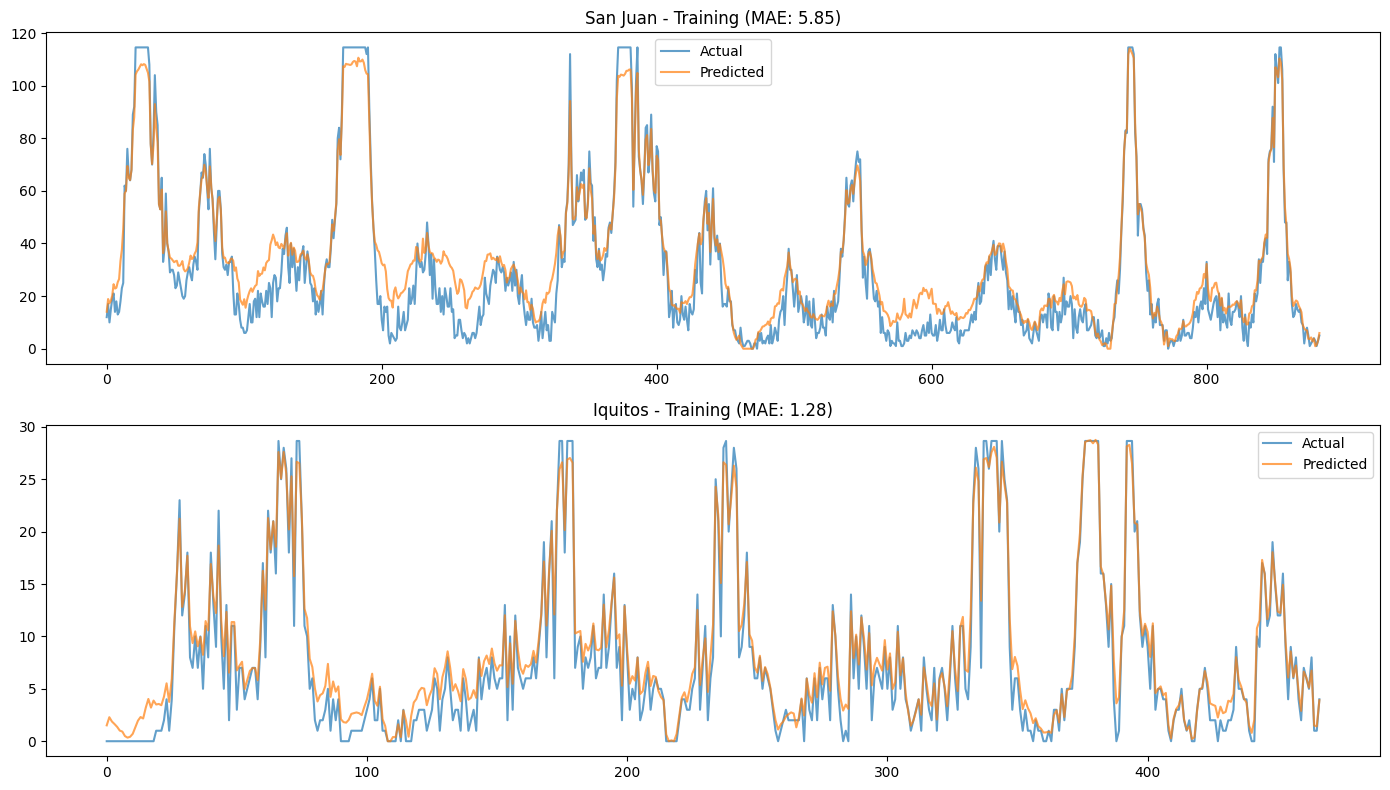

In [18]:
# EVALUATE ON TRAINING DATA

sj_train_preds = ensemble_predict(sj_models, X_sj)
sj_train_mae = mean_absolute_error(y_sj, sj_train_preds)
print(f"San Juan Training MAE: {sj_train_mae:.4f}")

iq_train_preds = ensemble_predict(iq_models, X_iq)
iq_train_mae = mean_absolute_error(y_iq, iq_train_preds)
print(f"Iquitos Training MAE: {iq_train_mae:.4f}")

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(y_sj.values, label='Actual', alpha=0.7)
axes[0].plot(sj_train_preds, label='Predicted', alpha=0.7)
axes[0].set_title(f'San Juan - Training (MAE: {sj_train_mae:.2f})')
axes[0].legend()

axes[1].plot(y_iq.values, label='Actual', alpha=0.7)
axes[1].plot(iq_train_preds, label='Predicted', alpha=0.7)
axes[1].set_title(f'Iquitos - Training (MAE: {iq_train_mae:.2f})')
axes[1].legend()

plt.tight_layout()
plt.show()

In [19]:
# PREPARE TEST FEATURES

def prepare_test_features(train_df, test_df, selected_features):
    """Combine train tail with test to generate features."""
    max_lookback = max(LAG_WEEKS + ROLLING_WEEKS + EWM_SPANS) + 10
    
    # Get train subset (matching test columns)
    common_cols = [c for c in train_df.columns if c in test_df.columns]
    train_subset = train_df[common_cols].tail(max_lookback)
    
    # Combine
    combined = pd.concat([train_subset, test_df])
    
    # Create features
    combined_eng = create_features(combined)
    
    # Get test portion
    test_eng = combined_eng.loc[test_df.index]
    
    # Select features (handle missing)
    available = [f for f in selected_features if f in test_eng.columns]
    return test_eng[available]


# Load test data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])

sj_test = preprocess_city_data(test_features.loc['sj'])
iq_test = preprocess_city_data(test_features.loc['iq'])

print("Preparing test features...")
X_test_sj = prepare_test_features(sj_train, sj_test, sj_selected)
X_test_iq = prepare_test_features(iq_train, iq_test, iq_selected)

print(f"San Juan Test: {X_test_sj.shape}")
print(f"Iquitos Test: {X_test_iq.shape}")

Preparing test features...
San Juan Test: (260, 50)
Iquitos Test: (156, 50)


In [20]:
# GENERATE PREDICTIONS

# Ensure columns match
sj_common_cols = [c for c in sj_selected if c in X_test_sj.columns]
iq_common_cols = [c for c in iq_selected if c in X_test_iq.columns]

# Retrain on common columns if needed
if len(sj_common_cols) < len(sj_selected):
    print(f"Warning: San Juan missing {len(sj_selected) - len(sj_common_cols)} features in test")
    X_sj_common = X_sj[sj_common_cols]
    sj_models = train_ensemble(X_sj_common, y_sj, sj_xgb_params, sj_lstm_params, OVERSAMPLE_THRESHOLD_SJ)

if len(iq_common_cols) < len(iq_selected):
    print(f"Warning: Iquitos missing {len(iq_selected) - len(iq_common_cols)} features in test")
    X_iq_common = X_iq[iq_common_cols]
    iq_models = train_ensemble(X_iq_common, y_iq, iq_xgb_params, iq_lstm_params, OVERSAMPLE_THRESHOLD_IQ)

# Predict
sj_preds = ensemble_predict(sj_models, X_test_sj[sj_common_cols]).astype(int)
iq_preds = ensemble_predict(iq_models, X_test_iq[iq_common_cols]).astype(int)

print(f"San Juan: {len(sj_preds)} predictions")
print(f"Iquitos: {len(iq_preds)} predictions")

San Juan: 260 predictions
Iquitos: 156 predictions


In [21]:
# CREATE SUBMISSION

submission = pd.read_csv(os.path.join(DATA_DIR, 'submission_format.csv'), index_col=[0, 1, 2])

submission.loc['sj', 'total_cases'] = sj_preds
submission.loc['iq', 'total_cases'] = iq_preds
;
# Save
submission_path = os.path.join(RESULT_DIR, 'submission_ensemble_xgb_lstm_svm.csv')
submission.to_csv(submission_path)

print(f"Submission saved to {submission_path}")
print("\nImprovements applied:")
print("  1. Cyclical time features (sin/cos)")
print("  2. Interaction features (temp × humidity)")
print("  3. Exponential weighted moving averages")
print("  4. Focused lag periods (dengue incubation)")
print("  5. Ensemble (XGBoost + LSTM + SVM)")
print("  8. Optuna hyperparameter tuning")
print("  9. Reduced oversampling (2x vs 5x)")
print("  10. Time series cross-validation")
print("  11. Outlier clipping")
print("  12. Recency-weighted samples")
print("  13. Single horizon (t+1)")
print("  17. Removed correlated features")

submission.head(10)

Submission saved to C:/term_project/results\submission_ensemble_xgb_lstm_svm.csv

Improvements applied:
  1. Cyclical time features (sin/cos)
  2. Interaction features (temp × humidity)
  3. Exponential weighted moving averages
  4. Focused lag periods (dengue incubation)
  5. Ensemble (XGBoost + LSTM + SVM)
  8. Optuna hyperparameter tuning
  9. Reduced oversampling (2x vs 5x)
  10. Time series cross-validation
  11. Outlier clipping
  12. Recency-weighted samples
  13. Single horizon (t+1)
  17. Removed correlated features


total_cases
city year weekofyear             
sj   2008 18                    4
          19                   11
          20                    9
          21                   10
          22                    9
          23                    9
          24                   11
          25                    9
          26                   11
          27                   12

In [ ]:
# SUBMISSION SCORE: 23.3149